# Descrição de Atividade

Nessa atividade você irá usar seus conhecimentos sobre classificação para prever quais candidatos à Câmara de Deputados foram eleitos nas eleições de 2014. De forma específica:

 1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)
 2. Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)
Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)
 3. Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)
 4. Envie seus melhores modelos à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo: (2 pts.)
 5. Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
 6. Experimente outras estratégias de ensembles (e.g. Stacking).
 7. Experimente balancear as classes,  caso estejam desbalanceadas.

Os dados estão neste link: https://www.kaggle.com/c/ufcg-cdp-20182-lab3/data. Links para um site externo

Para a entrega envie o link no GitHub com o notebook usado para resolver o Lab.


### Descrição dos dados:

Os dados utilizados correspondem aos das eleições de Deputado Federal nos anos de 2006, 2010 e 2014. Estão dividos nas seguintes colunas:

* **ano**: Ano da eleição;
* **sequencial_candidato**: O identificador do candidato. Corresponde à coluna Id do arquivo de submissão;
* **nome**: Nome do candidato;
* **uf**: Sigla do estado do candidato;
* **partido**: Partido do candidato;
* **quantidade_doacoes**: Número de doações que um candidato recebeu;
* **quantidade_doadores**: Numero de doadores que um candidato teve;
* **total_receita**: Total de receita de um candidato;
* **media_receita**: Média da receita de um candidato;
* **recursos_de_outros_candidatos.comites**: Total de receita proveniente de outros candidatos e comitês;
* **recursos_de_pessoas_fisicas**: Total de receita proveniente de pessoas físicas;
* **recursos_de_pessoas_juridicas**: Total de receita proveniente de pessoas juridicas;
* **recursos_proprios**:Total de receita proveniente dos próprios candidatos;
* **recursos_de_partido_politico**: Total de receita proveniente do partido do candidato;
* **quantidade_despesas**: Número de despesas que um candidato teve;
* **quantidade_fornecedores**: Número de fornecedores que um candidato teve;
* **total_despesa**: Total de depesa de um candidato;
* **media_despesa**: Média da despesa de um candidato;
* **cargo**: Cargo ao qual o candidato está concorrendo;
* **sexo**: Sexo do candidato;
* **grau**: Grau de escolaridade do candidato;
* **estado_civil**: Estado civil do candidato;
* **ocupacao**: Ocupação do candidato;
* **situacao**: Situação final do candidato. Corresponde à coluna **Predict** do arquivo de submissão;

## Import Libraries

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, cross_val_predict
from sklearn.externals.joblib import Parallel, delayed

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter

from enum import Enum

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

py.init_notebook_mode(connected=True)

sns.set(style="ticks")

## Load Data

In [3]:
train_df = pd.read_csv('../data/assignment_4/train.csv')
test_df = pd.read_csv('../data/assignment_4/test.csv')

data = pd.concat([train_df, test_df], sort=False)

data.set_index('sequencial_candidato', inplace=True, drop=True)

## Preprocess Data

In [4]:
data.drop(columns=['nome'], inplace=True)

In [5]:
qt = QuantileTransformer(random_state=2, output_distribution='normal')

skewed_features = ['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos.comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'recursos_de_partido_politico',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa']

data[skewed_features] = qt.fit_transform(X=data[skewed_features])

In [6]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}

data.replace(cleanup_nums, inplace=True)
data["grau"] = pd.to_numeric(data["grau"])

In [7]:
categorical_feats = [col for col in data.columns if not np.issubdtype(data[str(col)].dtype, np.number) and col not in ['nome', 'situacao']]

data = pd.get_dummies(data, columns=categorical_feats)
data.shape

(12214, 258)

## Split Data into Train and Test

In [8]:
data['situacao_dummy'] = data['situacao'].map({'eleito': 1, 'nao_eleito': 0})

train = data[(data.ano == 2006) | (data.ano == 2010)]
test = data[data.ano == 2014]

print(train.shape)
print(test.shape)

(7622, 259)
(4592, 259)


## Target Class Imbalancing

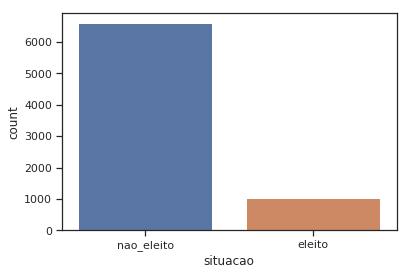

In [9]:
sns.countplot(x='situacao', data=train)

In [10]:
num_elected_candidates = train.situacao[train.situacao == 'eleito'].count()
num_not_elected_candidates = train.situacao[train.situacao == 'nao_eleito'].count()
total_candidates = train.shape[0]

print("Número de candidatos Eleitos: {}".format(num_elected_candidates))
print("Número de candidatos Não-Eleitos: {}".format(num_not_elected_candidates))
print("Total de candidatos: {}\n".format(total_candidates))

print("Proporção de candidatos eleitos: {:2.2%}".format((num_elected_candidates/total_candidates)))
print("Proporção de candidatos não-eleitos: {:2.2%}".format((num_not_elected_candidates/total_candidates)))

Número de candidatos Eleitos: 1026
Número de candidatos Não-Eleitos: 6596
Total de candidatos: 7622

Proporção de candidatos eleitos: 13.46%
Proporção de candidatos não-eleitos: 86.54%


A variável alvo **situacao** é bastante _desbalanceada_, em uma proporção de aproximadamente 1 eleito para cada 6 não-eleitos. Precisamente 13.46% dos candidatos foram eleitos, enquanto 86.54% não foram eleitos.

Esse desbalanceamento pode causar alguns efeitos colaterais na classificação feita pelo modelo preditor, tais como overfitting do modelo em relação à classe majoritária, o que prejudica a acurácia da predição, podendo causar até mesmo a interpretação incorreta dos resultados se o desbalanceamento não for endereçado corretamente.

Existem algumas práticas que podemos adotar para corrigir e lidar com esse desbalanceamento, a saber:

* Coleta de mais dados, que poderia rebalancear as classes, a depender da natureza do problema;
* Mudar a forma de amostragem do dataset, a qual pode estar gerando uma amostra desbalanceada, contudo o dataset não está desbalanceado;
* Usar alguma forma de gerar dados sintéticos como Synthetic Minority Over-sampling Technique [SMOTE](https://imbalanced-learn.org/en/stable/over_sampling.html#cbhk2002) e Adaptive Synthetic [ADASYN](https://imbalanced-learn.org/en/stable/over_sampling.html#hbgl2008);
* Incorporar algum modelo que tem uma forma de penalização para compensar o desbalanceamento de classes a exemplo de penalized-LDA e penalized-SVM.


Para essa atividade nós usaremos a técnica de geração de dados sintéticos SMOTE.

In [11]:
train.drop(['situacao'], axis=1, inplace=True)
test.drop(['situacao', 'situacao_dummy'], axis=1, inplace=True)

X = train.loc[:, train.columns != 'situacao_dummy']
y = train.situacao_dummy

X_train, y_train = SMOTE().fit_resample(X, y)
print("Train SMOTE: {}".format(sorted(Counter(y_train).items())))

#X_train = pd.DataFrame(X_train, columns=X.columns)

X_test = test
print("Test.shape: {}".format(X_test.shape))

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Train SMOTE: [(0.0, 6596), (1.0, 6596)]
Test.shape: (4592, 257)


## Split Train and Validation

In [12]:
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print("Train: {}".format(X_train.shape, y_train.shape))
#print("Test: {}".format(X_test.shape, y_test.shape))

## Modelos

In [13]:
class ModelsPaths(Enum):
    KNR_PATH = 'assignment4-models/knr.p'
    LR_PATH = 'assignment4-models/lr.p'
    DT_PATH = 'assignment4-models/dt.p'
    ADA_PATH = 'assignment4-models/ada.p'
    RF_PATH = 'assignment4-models/rf.p'
    ET_PATH = 'assignment4-models/et.p'
    SVC_PATH = 'assignment4-models/svc.p'
    LGBM_PATH = 'assignment4-models/lgbm.p'
    CAT_PATH = 'assignment4-models/cat.p'
    XGB_PATH = 'assignment4-models/xgb.p'

class ModelsNames(Enum):
    LR = 'Logistic Regression'
    DT = 'Decision Trees'
    ET = 'Extra Trees'
    RF = 'Random Forest'
    ADA = 'AdaBoost'
    SVC = 'Support Vector Machine'
    LGBM = 'LGBM'
    CAT = 'CatBoost'
    XGB = 'XGBoost'
    KNR = 'KNR'

#### Auxiliary Functions

In [14]:
def save_trained_model(self, path):
    pickle.dump(self.model, open(path.value, 'wb'))

def load_trained_model(self, path):
    return pickle.load(open(path.value, 'rb'))

def _get_top_10_features_and_imps(self, f_names, f_imps):
    aux = [(f_name, f_imp) for f_idx_a, f_name in f_names for f_idx_b, f_imp in f_imps if f_idx_a == f_idx_b]
    aux.sort(key=lambda tup: -tup[1]) # sort by feature_importance, descending order

    top_10_features = aux[:10]
    features_names = [x for x,_ in top_10_features]
    features_imps = [y for _,y in top_10_features]

    return (features_names, features_imps)

def _get_feat_names_and_imps_1(self):
    f_names = [(f_idx, f_name) for f_idx, f_name in enumerate(train.columns)]
    f_imps = [(f_idx, f_imp) for f_idx, f_imp in enumerate(self.model.feature_importances_)]

    return _get_top_10_features_and_imps(f_names, f_imps)

def _get_feat_names_and_imps_2(self):
    imps = (np.std(X_train, 0) * self.model.coef_)[0]

    f_names = [(f_idx, f_name) for f_idx, f_name in enumerate(train.columns)]
    f_imps = [(f_idx, f_imp) for f_idx, f_imp in enumerate(imps)]

    return _get_top_10_features_and_imps(f_names, f_imps)


def _plot_graph(self, model_name, features_names, features_imps):
    # Scatter plot 
    trace = go.Scatter(
        y = features_imps,
        x = features_names,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
            color = features_imps,
            colorscale='Portland',
            showscale=True
        ),
        text = features_names
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= '{} Feature Importance'.format(model_name.value),
        hovermode= 'closest',
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='scatter2010')


def plot_feature_importances(self, model_name):
    feature_names, feature_imps = None,None

    if model_name in [ModelsNames.DT, ModelsNames.ET, ModelsNames.RF, ModelsNames.ADA]:
        feature_names, feature_imps = _get_feat_names_and_imps_1()
    elif model_name in [ModelsNames.LR]:
        feature_names, feature_imps = _get_feat_names_and_imps_2()

    _plot_graph(model_name, feature_names, feature_imps)

#### Model Definitions

Abaixo definimos alguns wrappers para os modelos que vamos utilizar. Créditos para [**eliotbarr**](https://www.kaggle.com/eliotbarr/stacking-test-sklearn-xgboost-catboost-lightgbm/code) e [**arthurtok**](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python) no Kaggle.

In [15]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]

NFOLDS = 3
SEED = 42

class GenericWrapper(object):
    def __init__(self, clf, params=None):
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)[:,1]

class SklearnWrapper_1(GenericWrapper):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        super().__init__(clf, params)
    
    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)
    
class SklearnWrapper_2(GenericWrapper):
    def __init__(self, clf, params=None):
        super().__init__(clf, params)
    
    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)
    
    
class CatboostWrapper(GenericWrapper):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)
        
class LightGBMWrapper(GenericWrapper):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)


class XgbWrapper(GenericWrapper):
    def __init__(self, clf, seed=0, params=None):
        params['seed'] = seed
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)

In [22]:
def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_proba = np.zeros((ntest,))
    
    oof_test_skf = np.empty((NFOLDS, ntest))
    oof_test_skf_proba = np.empty((NFOLDS, ntest))
    
    kf = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=NFOLDS)
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        x_tr = X_train[train_index]
        y_tr = y_train[train_index]
        x_te = X_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(X_test)
        oof_test_skf_proba[i, :] = clf.predict_proba(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    oof_test_proba[:] = oof_test_skf_proba.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), oof_test_proba.reshape(-1,1)

#### Model Parameters

In [17]:
lr_params = {
    'solver': 'liblinear'
}

knr_params = {
    'n_neighbors': 3
}

dt_params = {
}

ada_params = {
    'learning_rate': 0.01
}

et_params = {
    #'n_jobs': 16,
    #'n_estimators': 200,
    #'max_features': 0.5,
    #'max_depth': 12,
    #'min_samples_leaf': 2
}

rf_params = {
    #'n_jobs': 16,
    #'n_estimators': 200,
    #'max_features': 0.2,
    #'max_depth': 12,
    #'min_samples_leaf': 2
}

svc_params = {
    'probability': True,
    'gamma' : 'auto'
}

xgb_params = {
    #'colsample_bytree': 0.7,
    'silent': 1,
    #'subsample': 0.7,
    'learning_rate': 0.1,
    #'objective': 'binary:logistic',
    #'max_depth': 4,
    #'num_parallel_tree': 1,
    #'min_child_weight': 1,
    'nrounds': 200
}

catboost_params = {
    'iterations': 200,
    'learning_rate': 0.5,
    'depth': 3,
    #'l2_leaf_reg': 40,
    #'bootstrap_type': 'Bernoulli',
    #'subsample': 0.7,
    #'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    #'od_type': 'Iter',
    'allow_writing_files': False,
    'verbose': 0
}

lightgbm_params = {
    #'n_estimators':200,
    'learning_rate':0.1,
    #'num_leaves':123,
    #'colsample_bytree':0.8,
    #'subsample':0.9,
    #'max_depth':15,
    #'reg_alpha':0.1,
    #'reg_lambda':0.1,
    #'min_split_gain':0.01,
    #'min_child_weight':2  ,
    'silent': 1,
    'random_state': 42
}

### Models

#### **_KNN (K-Nearest Neighbors)_**

In [ ]:
knr = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)

report_cross_validation_results(knr)
report_results_with_test_set(knr)
save_trained_model(knr, ModelsPaths.KNR_PATH)

#### **_Logistic Regression_**

In [ ]:
lr = LogisticRegression(random_state=42).fit(X_train, y_train)

report_cross_validation_results(lr)
report_results_with_test_set(lr)
save_trained_model(lr, ModelsPaths.LR_PATH)

#### _**Decision Tree Classifier**_

In [ ]:
dt = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)

report_cross_validation_results(dt)
report_results_with_test_set(dt)
save_trained_model(dt, ModelsPaths.DT_PATH)

#### **_Adaboost Ensemble_**

In [ ]:
ada = AdaBoostClassifier(random_state=42, learning_rate=0.01).fit(X_train, y_train)

report_cross_validation_results(ada)
report_results_with_test_set(ada)
save_trained_model(ada, ModelsPaths.ADA_PATH)

#### **_Random Forest Classifier_**

In [ ]:
rf = RandomForestClassifier(random_state = 42).fit(X_train, y_train)

report_cross_validation_results(rf)
report_results_with_test_set(rf)
save_trained_model(rf, ModelsPaths.RF_PATH)

#### **_Extra Trees Classifier_**

In [ ]:
et = ExtraTreesClassifier(random_state=42).fit(X_train, y_train)

report_cross_validation_results(et)
report_results_with_test_set(et)
save_trained_model(et, ModelsPaths.ET_PATH)

#### **_Support Vector Classifier_**

In [ ]:
svc = SVC(random_state=42, probability=True).fit(X_train, y_train)

report_cross_validation_results(svc)
report_results_with_test_set(svc)
save_trained_model(svc, ModelsPaths.SVC_PATH)

#### **_Gradient Boosting Classifier - LightGBM_**

In [ ]:
lgbm = LGBMClassifier(silent=1, random_state=42, learning_rate=0.1).fit(X_train, y_train)

report_cross_validation_results(lgbm)
report_results_with_test_set(lgbm)
save_trained_model(lgbm, ModelsPaths.LGBM_PATH)

#### **_Gradient Boosting Classifier - CatBoost_**

In [ ]:
cat = CatBoostClassifier(random_state=42, learning_rate=0.5, allow_writing_files=False, verbose=0, iterations=200, depth=3).fit(X_train, y_train)

report_cross_validation_results(cat)
report_results_with_test_set(cat)
save_trained_model(cat, ModelsPaths.CAT_PATH)

#### **_Gradient Boosting Classifier - XGBoost_**

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, silent=1, seed=42).fit(X_train, y_train)

report_cross_validation_results(xgb)
report_results_with_test_set(xgb)
save_trained_model(xgb, ModelsPaths.XGB_PATH)

## Feature Importances Plots

Abaixo listamos as 10 features mais importantes elencadas por diferentes modelos que usamos, após o treinamento destes. Créditos para [**arthurtok**](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook) no Kaggle.

### Decision Tress, AdaBoost, Random Forest Classifier e Extra Trees Classifier

In [ ]:
dt   = load_trained_model(ModelsPaths.DT_PATH)
ada  = load_trained_model(ModelsPaths.ADA_PATH)
rf   = load_trained_model(ModelsPaths.RF_PATH)
et   = load_trained_model(ModelsPaths.ET_PATH)

models = [(dt, ModelsNames.DT), (ada, ModelsNames.ADA), (rf, ModelsNames.RF), (et, ModelsNames.ET)]

for model, model_name in models:
    plot_feature_importances(model, model_name)

Podemos observar que esses modelos divergem quanto à principal feature que deve ser considerada para que um candidato seja eleito. Entretanto, podemos ver algumas que se repetem e que eles consideram como tendo maior importância:

* total receita
* ocupação Deputado (candidatos tentando reeleição)
* total despesa
* recursos obtidos (pessoas jurídicas, pessoas físicas, etc.)



### Logistic Regression

In [ ]:
lr   = load_trained_model(ModelsPaths.LR_PATH)
plot_feature_importances(lr, ModelsNames.LR)

### KNR

In [ ]:
knr  = load_trained_model(ModelsPaths.KNR_PATH)
svc  = load_trained_model(ModelsPaths.SVC_PATH)
lgbm = load_trained_model(ModelsPaths.LGBM_PATH)
cat  = load_trained_model(ModelsPaths.CAT_PATH)
xgb  = load_trained_model(ModelsPaths.XGB_PATH)

# Second Level Training - Stacking

#### _**Logistic Regression-based Stacking Classifier**_

In [87]:
lr = SklearnWrapper_1(clf=LogisticRegression, params=lr_params)
ad = SklearnWrapper_1(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
et = SklearnWrapper_1(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper_1(clf=RandomForestClassifier, seed=SEED, params=rf_params)
dt = SklearnWrapper_1(clf=DecisionTreeClassifier, seed=SEED, params=dt_params)
sv = SklearnWrapper_1(clf=SVC, seed=SEED, params=svc_params)
kn = SklearnWrapper_2(clf=KNeighborsClassifier, params=knr_params)
lg = LightGBMWrapper(clf = LGBMClassifier, seed = SEED, params = lightgbm_params)
cb = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params)
xg = XgbWrapper(clf=XGBClassifier, seed=SEED, params=xgb_params)

lr_oof_train, lr_oof_test, lr_oof_test_proba = get_oof(lr)
ad_oof_train, ad_oof_test, ad_oof_test_proba = get_oof(ad)
et_oof_train, et_oof_test, et_oof_test_proba = get_oof(et)
rf_oof_train, rf_oof_test, rf_oof_test_proba = get_oof(rf)
dt_oof_train, dt_oof_test, dt_oof_test_proba = get_oof(dt)
sv_oof_train, sv_oof_test, sv_oof_test_proba = get_oof(sv)
kn_oof_train, kn_oof_test, kn_oof_test_proba = get_oof(kn)
lg_oof_train, lg_oof_test, lg_oof_test_proba = get_oof(lg)
cb_oof_train, cb_oof_test, cb_oof_test_proba = get_oof(cb)
xg_oof_train, xg_oof_test, xg_oof_test_proba = get_oof(xg)

ValueError: X has 258 features per sample; expecting 257

### Analyze Intermediary Model Performance

In [86]:
results = [(ModelsNames.LR, lr_oof_train), (ModelsNames.ADA, ad_oof_train), 
           (ModelsNames.ET, et_oof_train), (ModelsNames.RF, rf_oof_train), 
           (ModelsNames.DT, dt_oof_train), (ModelsNames.KNR, kn_oof_train), 
           (ModelsNames.SVC, sv_oof_train), (ModelsNames.LGBM, lg_oof_train), 
           (ModelsNames.CAT, cb_oof_train)]


for m_name, m_train_result in results:        
    print("Model: {}".format(m_name.value))
    print("Precision: {:.4}".format(precision_score(y_train, m_train_result)))
    print("Recall: {:.4}".format(recall_score(y_train, m_train_result)))
    print("F1: {:.4}".format(f1_score(y_train, m_train_result)))
    print("Accuracy: {:.4}".format(accuracy_score(y_train, m_train_result)))
    print("Roc_auc: {:.4}".format(roc_auc_score(y_train, m_train_result)))
    print("----------------------")

Model: Logistic Regression
Precision: 0.9033
Recall: 0.9591
F1: 0.9304
Accuracy: 0.9282
Roc_auc: 0.9282
----------------------
Model: AdaBoost
Precision: 0.8715
Recall: 0.9668
F1: 0.9167
Accuracy: 0.9121
Roc_auc: 0.9121
----------------------
Model: Extra Trees
Precision: 0.9425
Recall: 0.9817
F1: 0.9617
Accuracy: 0.9609
Roc_auc: 0.9609
----------------------
Model: Random Forest
Precision: 0.9301
Recall: 0.9659
F1: 0.9476
Accuracy: 0.9466
Roc_auc: 0.9466
----------------------
Model: Decision Trees
Precision: 0.9258
Recall: 0.9313
F1: 0.9286
Accuracy: 0.9284
Roc_auc: 0.9284
----------------------
Model: KNR
Precision: 0.8759
Recall: 0.9983
F1: 0.9331
Accuracy: 0.9284
Roc_auc: 0.9284
----------------------
Model: Support Vector Machine
Precision: 0.8947
Recall: 0.9712
F1: 0.9314
Accuracy: 0.9284
Roc_auc: 0.9284
----------------------
Model: LGBM
Precision: 0.9425
Recall: 0.97
F1: 0.9561
Accuracy: 0.9554
Roc_auc: 0.9554
----------------------
Model: CatBoost
Precision: 0.9401
Recall: 0.

In [82]:
def evaluate_stacked_model(model):
    scoring = ['precision', 'recall', 'f1', 'accuracy', 'roc_auc']
    scores = cross_validate(model, x__train, y__train, cv=3, scoring=scoring)
    
    print("\nAvaliação de Stacked Model com CV:")
    print("Precision: {:.4}".format(scores['test_precision'].mean()))
    print("Recall: {:.4}".format(scores['test_recall'].mean()))
    print("F1: {:.4}".format(scores['test_f1'].mean()))
    print("Accuracy: {:.4}".format(scores['test_accuracy'].mean()))
    print("Roc_auc: {:.4}".format(scores['test_roc_auc'].mean()))

In [83]:
x__train = np.concatenate((lr_oof_train, ad_oof_train, et_oof_train, rf_oof_train, dt_oof_train,
                          kn_oof_train, sv_oof_train, lg_oof_train, cb_oof_train), axis=1)
x__test = np.concatenate((lr_oof_test, ad_oof_test, et_oof_test, rf_oof_test, dt_oof_test,
                         kn_oof_test, sv_oof_test, lg_oof_test, cb_oof_test), axis=1)
y__train = y_train.copy()

print("x__train.shape: {}".format(x__train.shape))
print("y__train.shape: {}".format(y__train.shape))
print("x__test.shape:{}".format(x__test.shape))

scoring = ['precision', 'recall', 'f1', 'accuracy', 'roc_auc']
clf = LogisticRegression(solver='liblinear')
clf.fit(x__train, y__train)

evaluate_stacked_model(clf)

x__train.shape: (13192, 9)
y__train.shape: (13192,)
x__test.shape:(4592, 9)

Avaliação de Stacked Model com CV:
Precision: 0.9488
Recall: 0.9623
F1: 0.955
Accuracy: 0.9553
Roc_auc: 0.9767


#### Generate Prediction to Test Data

In [69]:
stack_df = pd.DataFrame(X_test)
pred = logistic_regression.predict(x__test)
stack_df['Predicted'] = pred

seq_candidato = stack_df.index

stack_df.replace({'Predicted': {0: 'nao_eleito', 1: 'eleito'}}, inplace=True)
stack_df.reset_index(drop=True, inplace=True)

final_df = pd.DataFrame(columns=['Id','Predicted'])
final_df['Id'] = seq_candidato
final_df['Predicted'] = stack_df['Predicted']

final_df.to_csv('../data/assignment_4/second_submission.csv', index=False)
final_df.head(10)

,Id,Predicted
0,10000000135,nao_eleito
1,10000000142,nao_eleito
2,10000000158,eleito
3,10000000161,nao_eleito
4,10000000163,eleito


In [ ]:
origin_models = ['knr','lr','dt','ada','rf','svc','et','lgbm','cat','xgb']

stack_df = pd.DataFrame(columns=origin_models + ['oracle'])

stack_df['knr'] = knr.predict_proba(X_test)[:,1]
stack_df['lr'] = lr.predict_proba(X_test)[:,1]
stack_df['dt'] = dt.predict_proba(X_test)[:,1]
stack_df['ada'] = ada.predict_proba(X_test)[:,1]
stack_df['rf'] = rf.predict_proba(X_test)[:,1]
stack_df['svc'] = svc.predict_proba(X_test)[:,1]
stack_df['et'] = et.predict_proba(X_test)[:,1]
stack_df['lgbm'] = lgbm.predict_proba(X_test)[:,1]
stack_df['cat'] = cat.predict_proba(X_test)[:,1]
stack_df['xgb'] = xgb.predict_proba(X_test)[:,1]
stack_df['oracle'] = y_test

stack_df.head()

Previouslly:

* Precision: 0.9481
* Recall: 0.9884
* F1: 0.9679
* Accuracy: 0.9678
* Roc_auc: 0.9682

After add XGBoostClassifier:

* Precision: 0.9658
* Recall: 0.9807
* F1: 0.9732
* Accuracy: 0.9735
* Roc_auc: 0.9736

In [ ]:
x__train, x__test, y__train, y__test = train_test_split(stack_df[origin_models], stack_df.oracle, test_size=0.2, random_state=42)

stack_lr = LogisticRegression(solver='liblinear').fit(x__train, y__train)
pred = stack_lr.predict(x__test)

print('Precision: {:.4}'.format(precision_score(y__test, pred)))
print('Recall: {:.4}'.format(recall_score(y__test, pred)))
print('F1: {:.4}'.format(f1_score(y__test, pred)))
print('Accuracy: {:.4}'.format(accuracy_score(y__test, pred)))
print('Roc_auc: {:.4}'.format(roc_auc_score(y__test, pred)))

## EXTRA - Usando Pipelines e GridSearch do Scikit Learn

Abaixo nós fazemos alguns pipelines e grid searches com os mesmos algoritmos usados acima com o intuito de checar se os valores obtidos são correspondentes.

### Conclusão

Como se observa acima, o melhor modelo encontrado foi o modelo **Lasso Regressor** em termos de RMSE, com o modelo **Ridge Regressor** bem próximo dele em termos de RMSE.

Entretanto os valores de RMSE são distintos dos valores encontrados acima. Isso pode se dever ao ajuste dos parâmetros dos modelos, feitos durante a própria busca, e/ou por alguma diferença na função de scoring, que talvez tenha passado despercebida pela nossa análise.